In [2]:
import numpy as np
import sklearn
import scipy.stats
import matplotlib.pyplot as plt
import random
import math

First let's make some signal data with a multivariate Gaussian

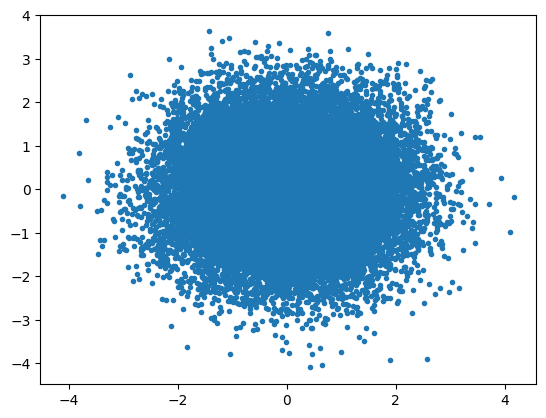

In [3]:
def genSignal(nToGen):
    _data = scipy.stats.multivariate_normal([0,0], [[1.,0.],[0.,1.]]).rvs(nToGen)
    return _data
sig_frame = genSignal(30000)
plt.scatter(sig_frame[:,0], sig_frame[:,1], marker = '.')

Now we make some background data that is in a ring around the signal distribution

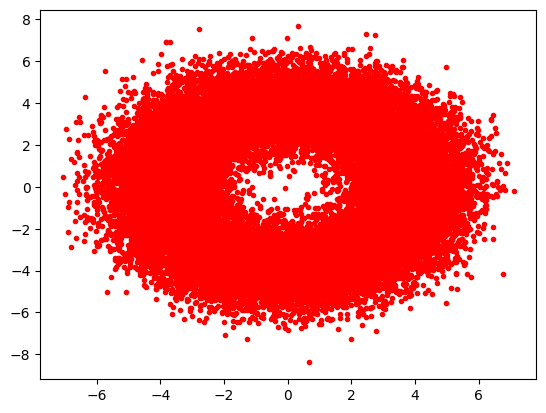

In [4]:
def genBkg(nToGen):
    th = random.random()*2.*math.pi
    r = 4
    _data = [scipy.stats.multivariate_normal([0,0], [[0.5,0.],[0.,0.5]]).rvs(1)]
    for i in range(nToGen):
        th = random.random()*2.*math.pi
        _data = np.append(_data, [scipy.stats.multivariate_normal([r*math.cos(th),r*math.sin(th)], [[1,0.],[0.,1.]]).rvs(1)], axis=0)
    return _data   
        

bkg_frame = genBkg(30000)
plt.scatter(bkg_frame[:,0], bkg_frame[:,1], marker = '.', color = 'r')

And plot the two together

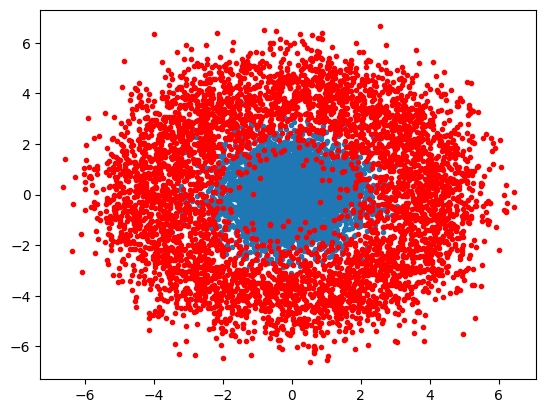

In [5]:
plt.scatter(sig_frame[:5000,0], sig_frame[:5000,1], marker = '.')
plt.scatter(bkg_frame[:5000,0], bkg_frame[:5000,1], marker = '.', color = 'r')

Let's look at the 1D distributions

(array([   6.,  517., 3732., 5499., 4169., 4068., 5044., 5235., 1656.,
          75.]),
 array([-8.38819363, -6.78371528, -5.17923693, -3.57475858, -1.97028023,
        -0.36580188,  1.23867647,  2.84315482,  4.44763317,  6.05211152,
         7.65658987]),
 <BarContainer object of 10 artists>)

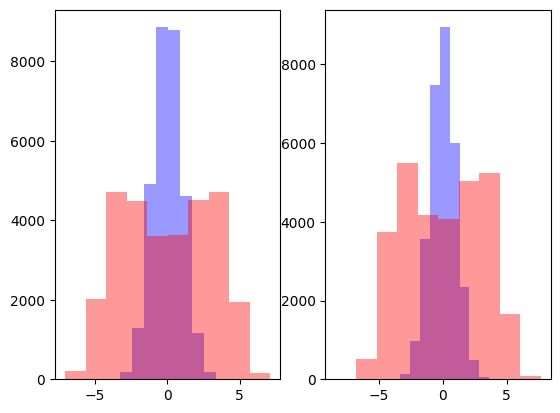

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(sig_frame[:,0], color = 'blue', alpha = 0.4)
ax1.hist(bkg_frame[:,0], color = 'red', alpha = 0.4)

ax2.hist(sig_frame[:,1], color = 'blue', alpha = 0.4)
ax2.hist(bkg_frame[:,1], color = 'red', alpha = 0.4)



Looking at the 1D projections we can probably make a fairly efficient selections by some 1D cuts. However the 2D projection shows that a circle would be better - an MVA is required.

For this example we should use a Boosted Decision Tree (BDT). It is a collection of decision trees, with ADABoost.

In [7]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import DecisionBoundaryDisplay

In [8]:
# First set up the BDT
bdt = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2), algorithm="SAMME", n_estimators=200
)
# The max depth and number of estimators are two hyperparameters that can be tuned for optimal performance

# Now make a training data set from half the generated signal and background
# We make an array of the data and an array of labels for signal (1) and bkg (0)
X_train = np.concatenate([sig_frame[:15000], bkg_frame[:15000]])
Y_train = np.concatenate([np.ones(15000), np.zeros(15000)])
# We also make a statistically independent test set from the other half
X_test = np.concatenate([sig_frame[15000:30000], bkg_frame[15000:30000]])
Y_test = np.concatenate([np.ones(15000), np.zeros(15000)])

Text(0.5, 0, 'BDT output')

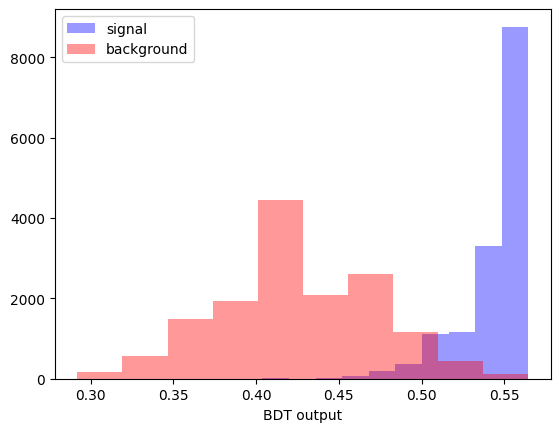

In [11]:
# Now fit the BDT to the training data and then see what it does to the test
bdt.fit(X_train,Y_train)
bdt_score = bdt.predict_proba(X_test)

# Plot the probability of label 1 (signal) for the signal and bkg samples
plt.hist(bdt_score[Y_test==1][:,1], color = 'blue', alpha= 0.4, label='signal')
plt.hist(bdt_score[Y_test==0][:,1], color = 'red', alpha= 0.4, label = 'background')
plt.legend()
plt.xlabel('BDT output')

We can visualise the decision boundary of the BDT. You can see the BDT has learned that the signal and background are separated by a circle and so learned that cut.

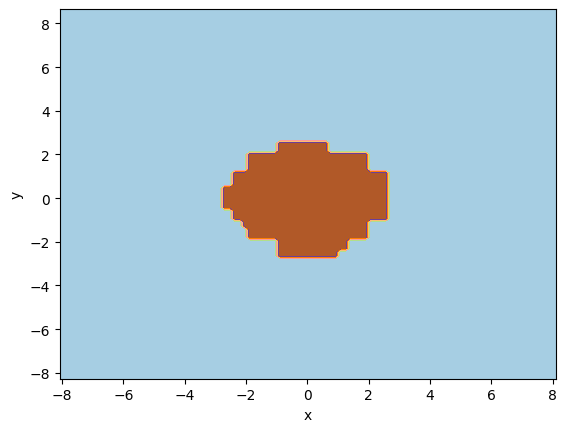

In [12]:
plt.figure()
ax = plt.gca()
disp = DecisionBoundaryDisplay.from_estimator(
    bdt,
    X_test,
    cmap=plt.cm.Paired,
    response_method="predict",
    ax=ax,
    xlabel="x",
    ylabel="y",
)